<a href="https://colab.research.google.com/github/HarxSan/BigVision_Triangle_Detection/blob/main/BigVision_Task_Triangle_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %% Colab Setup and Environment Preparation
%%capture
!pip install ultralytics albumentations matplotlib seaborn opencv-python-headless scikit-learn --quiet
!sudo apt-get install tree -qq

In [3]:
import os
import cv2
import time
import numpy as np
import albumentations as A
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from pathlib import Path
from tqdm.auto import tqdm
import random
import shutil

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

# Mount Google Drive for model saving
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# %% Dataset Configuration - Optimized for T4 GPU
class CFG:
    # Directory structure
    BASE_DIR = "/content/triangle_dataset"
    IMAGE_DIR = os.path.join(BASE_DIR, "images")
    LABEL_DIR = os.path.join(BASE_DIR, "labels")

    # Dataset parameters
    TOTAL_IMAGES = 1500  # (800 train, 350 val, 350 test)
    IMG_SIZE = 640
    TEST_SIZE = 0.23
    VAL_SIZE = 0.23
    NEGATIVE_RATIO = 0.2  # 20% images without triangles

    # Image variety parameters
    BG_TYPES = ['solid', 'gradient', 'noise', 'texture']
    BG_PROBS = [0.25, 0.3, 0.25, 0.2]

    # Triangle variety parameters
    MIN_TRIANGLE_AREA = 900
    MAX_TRIANGLES = 5
    TRIANGLE_TYPES = ['regular', 'thin', 'obtuse', 'right']

    # YOLO training
    MODEL_TYPE = "yolov8n.pt"  # Using nano model for speed
    EPOCHS = 100
    BATCH = 16
    PATIENCE = 20
    WORKERS = 2

    # Augmentation strengths
    AUG_ROTATE_LIMIT = 45
    AUG_SCALE_LIMIT = 0.2

    SAVE_DIR = "/content/drive/MyDrive/triangle_detection_rerun"

    # Visualizations
    PLOT_METRICS = True
    CONFUSION_MATRIX = True
    TEST_SAMPLES = 8

# Create directories
for dir_path in [CFG.BASE_DIR, CFG.IMAGE_DIR, CFG.LABEL_DIR]:
    os.makedirs(dir_path, exist_ok=True)

In [5]:
# %% Enhanced Synthetic Dataset Generation
def generate_background():
    """Create diverse backgrounds with 4 different types"""
    bg_type = np.random.choice(CFG.BG_TYPES, p=CFG.BG_PROBS)
    img = np.zeros((CFG.IMG_SIZE, CFG.IMG_SIZE, 3), dtype=np.uint8)

    if bg_type == 'solid':
        # Solid color with slight noise for realism
        base_color = np.random.randint(0, 256, 3)
        noise = np.random.randint(-20, 20, (CFG.IMG_SIZE, CFG.IMG_SIZE, 3))
        img = np.clip(np.full((CFG.IMG_SIZE, CFG.IMG_SIZE, 3), base_color) + noise, 0, 255).astype(np.uint8)

    elif bg_type == 'gradient':
        if np.random.random() < 0.7:
            angle = np.random.randint(0, 360)
            c1, c2 = np.random.randint(0, 256, 3), np.random.randint(0, 256, 3)

            y, x = np.mgrid[0:CFG.IMG_SIZE, 0:CFG.IMG_SIZE]
            if angle < 90:
                mask = (x + y) / (2 * CFG.IMG_SIZE)
            elif angle < 180:
                mask = (CFG.IMG_SIZE - x + y) / (2 * CFG.IMG_SIZE)
            elif angle < 270:
                mask = (CFG.IMG_SIZE - x + CFG.IMG_SIZE - y) / (2 * CFG.IMG_SIZE)
            else:
                mask = (x + CFG.IMG_SIZE - y) / (2 * CFG.IMG_SIZE)

            for i in range(3):
                img[:,:,i] = (c1[i] * (1 - mask) + c2[i] * mask).astype(np.uint8)

        else:
            c1, c2 = np.random.randint(0, 256, 3), np.random.randint(0, 256, 3)
            center = (CFG.IMG_SIZE // 2, CFG.IMG_SIZE // 2)
            y, x = np.mgrid[0:CFG.IMG_SIZE, 0:CFG.IMG_SIZE]

            dist = np.sqrt((x - center[0])**2 + (y - center[1])**2)
            max_dist = np.sqrt(2) * CFG.IMG_SIZE / 2
            mask = np.clip(dist / max_dist, 0, 1)

            for i in range(3):
                img[:,:,i] = (c1[i] * (1 - mask) + c2[i] * mask).astype(np.uint8)

    elif bg_type == 'noise':
        noise_type = np.random.choice(['uniform', 'gaussian', 'salt_pepper'])

        if noise_type == 'uniform':
            img = np.random.randint(0, 256, (CFG.IMG_SIZE, CFG.IMG_SIZE, 3)).astype(np.uint8)

        elif noise_type == 'gaussian':
            mean = np.random.randint(0, 256)
            std = np.random.randint(5, 60)
            img = np.random.normal(mean, std, (CFG.IMG_SIZE, CFG.IMG_SIZE, 3))
            img = np.clip(img, 0, 255).astype(np.uint8)

        else:
            img = np.random.randint(30, 200, (CFG.IMG_SIZE, CFG.IMG_SIZE, 3)).astype(np.uint8)
            mask = np.random.random((CFG.IMG_SIZE, CFG.IMG_SIZE)) < 0.05
            img[mask] = 255
            mask = np.random.random((CFG.IMG_SIZE, CFG.IMG_SIZE)) < 0.05
            img[mask] = 0

    else:
        texture_type = np.random.choice(['grid', 'checker', 'voronoi'])

        if texture_type == 'grid':
            grid_size = np.random.randint(20, 100)
            color1 = np.random.randint(0, 256, 3)
            color2 = np.random.randint(0, 256, 3)

            x_grid = (np.arange(CFG.IMG_SIZE) // grid_size) % 2
            y_grid = (np.arange(CFG.IMG_SIZE) // grid_size) % 2
            grid = np.logical_xor.outer(x_grid, y_grid).astype(int)

            for i in range(3):
                img[:,:,i] = grid * color1[i] + (1 - grid) * color2[i]

        elif texture_type == 'checker':
            checker_size = np.random.randint(30, 120)
            color1 = np.random.randint(0, 256, 3)
            color2 = np.random.randint(0, 256, 3)

            x_check = (np.arange(CFG.IMG_SIZE) // checker_size) % 2
            y_check = (np.arange(CFG.IMG_SIZE) // checker_size) % 2
            checker = np.logical_xor.outer(x_check, y_check).astype(int)

            for i in range(3):
                img[:,:,i] = checker * color1[i] + (1 - checker) * color2[i]

        else:
            num_centers = np.random.randint(5, 20)
            centers = np.random.randint(0, CFG.IMG_SIZE, (num_centers, 2))
            colors = np.random.randint(0, 256, (num_centers, 3))

            y, x = np.mgrid[0:CFG.IMG_SIZE, 0:CFG.IMG_SIZE]

            # Calculate distances to each center
            distances = np.zeros((num_centers, CFG.IMG_SIZE, CFG.IMG_SIZE))
            for i in range(num_centers):
                distances[i] = np.sqrt((x - centers[i, 0])**2 + (y - centers[i, 1])**2)

            # Find closest center
            closest = np.argmin(distances, axis=0)

            # Assign colors
            for i in range(num_centers):
                mask = (closest == i)
                img[mask] = colors[i]

    return img

def create_triangle(triangle_type='random'):
    """Generate random triangle coordinates based on type"""
    if triangle_type == 'random':
        triangle_type = np.random.choice(CFG.TRIANGLE_TYPES)

    min_area = CFG.MIN_TRIANGLE_AREA
    margin = 10
    max_attempts = 100

    for _ in range(max_attempts):
        size = np.random.randint(50, CFG.IMG_SIZE // 2)
        x = np.random.randint(margin, CFG.IMG_SIZE - size - margin)
        y = np.random.randint(margin, CFG.IMG_SIZE - size - margin)

        if triangle_type == 'regular':
            angles = np.sort(np.random.uniform(0, 2*np.pi, 3))
            pts = np.array([
                [x + int(size * np.cos(a)), y + int(size * np.sin(a))]
                for a in angles
            ])
        elif triangle_type == 'thin':
            pts = np.array([
                [x, y],
                [x + np.random.randint(size//4, size//2), y + size],
                [x + np.random.randint(size//2, size), y]
            ])
        elif triangle_type == 'obtuse':
            pts = np.array([
                [x, y],
                [x + size, y],
                [x + np.random.randint(size//4, 3*size//4), y - np.random.randint(size//2, size)]
            ])
        else:  # right
            pts = np.array([
                [x, y],
                [x + size, y],
                [x, y + size]
            ])

        # Apply random rotation
        if np.random.random() < 0.7:
            center = tuple(map(int, pts.mean(axis=0)))
            rotation_matrix = cv2.getRotationMatrix2D(center, np.random.randint(0, 360), 1.0)
            pts = np.hstack((pts, np.ones((3, 1), dtype=np.float32)))
            pts = (rotation_matrix @ pts.T).T
            pts = np.clip(pts, margin, CFG.IMG_SIZE - margin).astype(int)

        # Check if area is sufficient
        area = cv2.contourArea(pts)
        if area >= min_area:
            return pts

    # fallback simple triangle
    center_x = CFG.IMG_SIZE // 2
    center_y = CFG.IMG_SIZE // 2
    size = np.random.randint(40, CFG.IMG_SIZE // 3)

    return np.array([
        [center_x, center_y - size // 2],
        [center_x - size // 2, center_y + size // 2],
        [center_x + size // 2, center_y + size // 2]
    ])

def get_triangle_color(background):
    """Generate a triangle color that contrasts with the background"""
    bg_center = background[background.shape[0]//2, background.shape[1]//2]

    # Determine if background is light or dark
    is_dark = np.mean(bg_center) < 128

    if is_dark:
        # Light triangle on dark background
        base = np.random.randint(150, 256, 3)
    else:
        # Dark triangle on light background
        base = np.random.randint(0, 100, 3)

    # Add some randomness
    color = base + np.random.randint(-30, 30, 3)
    return np.clip(color, 0, 255).tolist()

def draw_triangle_with_effects(img, triangle, color):
    """Draw a triangle with optional effects for realism"""
    # Create a copy for blending
    img_copy = img.copy()

    # Fill the triangle
    cv2.fillPoly(img_copy, [triangle], color)

    # Apply effects
    effect = np.random.choice(['none', 'border', 'gradient', 'texture'], p=[0.4, 0.3, 0.2, 0.1])

    if effect == 'border':
        # Add border
        border_color = np.array(color) * 0.7
        cv2.polylines(img_copy, [triangle], True, border_color.astype(int).tolist(), thickness=np.random.randint(1, 5))

    elif effect == 'gradient':
        mask = np.zeros_like(img)
        cv2.fillPoly(mask, [triangle], (255, 255, 255))

        gradient = np.zeros_like(img)
        pt1 = tuple(triangle[0])
        pt2 = tuple(triangle[2])
        cv2.line(gradient, pt1, pt2, (50, 50, 50), 5)

        gradient_strength = np.random.uniform(0.1, 0.3)
        img_copy = cv2.addWeighted(img_copy, 1, cv2.bitwise_and(gradient, mask), gradient_strength, 0)

    elif effect == 'texture':
        # Add texture to triangle
        texture_mask = np.zeros((CFG.IMG_SIZE, CFG.IMG_SIZE), dtype=np.uint8)
        cv2.fillPoly(texture_mask, [triangle], 255)

        # Create noise texture
        noise = np.random.randint(0, 50, (CFG.IMG_SIZE, CFG.IMG_SIZE))

        # Apply noise where mask is active
        for c in range(3):
            channel = img_copy[:,:,c]
            channel[texture_mask == 255] = np.clip(channel[texture_mask == 255] + noise[texture_mask == 255] - 25, 0, 255)
            img_copy[:,:,c] = channel

    alpha = np.random.uniform(0.85, 1.0)
    img = cv2.addWeighted(img, 1-alpha, img_copy, alpha, 0)

    return img

In [6]:
# %% Enhanced Dataset Generation Pipeline
def generate_dataset():
    """Main dataset generation function with progress tracking and error handling"""
    print("Generating dataset...")

    triangle_counts = []
    triangle_areas = []

    for img_num in tqdm(range(CFG.TOTAL_IMAGES)):
        try:
            img = generate_background()
            label_file = os.path.join(CFG.LABEL_DIR, f"{img_num}.txt")

            if img_num < CFG.TOTAL_IMAGES * CFG.NEGATIVE_RATIO:
                num_triangles = 0
            else:
                weights = [0.5, 0.3, 0.15, 0.05]
                num_triangles = np.random.choice(range(1, CFG.MAX_TRIANGLES), p=weights[:CFG.MAX_TRIANGLES-1])

            triangle_counts.append(num_triangles)

            with open(label_file, 'w') as f:
                for _ in range(num_triangles):
                    triangle = create_triangle()

                    color = get_triangle_color(img)

                    img = draw_triangle_with_effects(img, triangle, color)

                    area = cv2.contourArea(triangle)
                    triangle_areas.append(area)

                    x_min, y_min = np.min(triangle, axis=0)
                    x_max, y_max = np.max(triangle, axis=0)

                    x_center = (x_min + x_max) / (2 * CFG.IMG_SIZE)
                    y_center = (y_min + y_max) / (2 * CFG.IMG_SIZE)
                    width = (x_max - x_min) / CFG.IMG_SIZE
                    height = (y_max - y_min) / CFG.IMG_SIZE

                    f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

            cv2.imwrite(os.path.join(CFG.IMAGE_DIR, f"{img_num}.jpg"), img)

        except Exception as e:
            print(f"Error generating image {img_num}: {e}")
            cv2.imwrite(os.path.join(CFG.IMAGE_DIR, f"{img_num}.jpg"),
                       np.full((CFG.IMG_SIZE, CFG.IMG_SIZE, 3), 128, dtype=np.uint8))
            with open(label_file, 'w') as f:
                pass

    print(f"\nDataset generated with {CFG.TOTAL_IMAGES} images")
    print(f"Negative samples: {int(CFG.TOTAL_IMAGES * CFG.NEGATIVE_RATIO)} ({CFG.NEGATIVE_RATIO*100:.1f}%)")
    print(f"Average triangles per positive image: {np.mean(triangle_counts):.2f}")
    if triangle_areas:
        print(f"Average triangle area: {np.mean(triangle_areas):.1f} px²")
        print(f"Min triangle area: {np.min(triangle_areas):.1f} px²")
        print(f"Max triangle area: {np.max(triangle_areas):.1f} px²")

start_time = time.time()
generate_dataset()
print(f"Dataset generation completed in {time.time() - start_time:.2f} seconds")

!tree {CFG.BASE_DIR} -L 2

Generating dataset...


  0%|          | 0/1500 [00:00<?, ?it/s]


Dataset generated with 1500 images
Negative samples: 300 (20.0%)
Average triangles per positive image: 1.39
Average triangle area: 16140.1 px²
Min triangle area: 901.0 px²
Max triangle area: 121954.0 px²
Dataset generation completed in 47.74 seconds
/content/triangle_dataset
├── images
│   ├── 0.jpg
│   ├── 1000.jpg
│   ├── 1001.jpg
│   ├── 1002.jpg
│   ├── 1003.jpg
│   ├── 1004.jpg
│   ├── 1005.jpg
│   ├── 1006.jpg
│   ├── 1007.jpg
│   ├── 1008.jpg
│   ├── 1009.jpg
│   ├── 100.jpg
│   ├── 1010.jpg
│   ├── 1011.jpg
│   ├── 1012.jpg
│   ├── 1013.jpg
│   ├── 1014.jpg
│   ├── 1015.jpg
│   ├── 1016.jpg
│   ├── 1017.jpg
│   ├── 1018.jpg
│   ├── 1019.jpg
│   ├── 101.jpg
│   ├── 1020.jpg
│   ├── 1021.jpg
│   ├── 1022.jpg
│   ├── 1023.jpg
│   ├── 1024.jpg
│   ├── 1025.jpg
│   ├── 1026.jpg
│   ├── 1027.jpg
│   ├── 1028.jpg
│   ├── 1029.jpg
│   ├── 102.jpg
│   ├── 1030.jpg
│   ├── 1031.jpg
│   ├── 1032.jpg
│   ├── 1033.jpg
│   ├── 1034.jpg
│   ├── 1035.jpg
│   ├── 1036.jpg
│   ├── 1037.jpg
│   

In [7]:
# %% Enhanced Dataset Split and Augmentation
def prepare_dataset_split():
    """Split dataset and create data.yaml file"""
    image_files = sorted([f for f in os.listdir(CFG.IMAGE_DIR) if f.endswith('.jpg')])

    image_paths = [os.path.abspath(os.path.join(CFG.IMAGE_DIR, f)) for f in image_files]

    # Create stratified split based on whether images have triangles or not
    has_triangles = []
    for img_file in image_files:
        label_file = os.path.join(CFG.LABEL_DIR, img_file.replace('.jpg', '.txt'))
        has_triangles.append(os.path.getsize(label_file) > 0)

    # Split dataset ensuring balanced distribution of positive/negative samples
    train_paths, temp_paths = train_test_split(
        list(zip(image_paths, has_triangles)),
        test_size=CFG.TEST_SIZE + CFG.VAL_SIZE,
        stratify=has_triangles,
        random_state=42
    )

    train_paths = [path for path, _ in train_paths]
    temp_images = [path for path, _ in temp_paths]
    temp_has_triangles = [has_triangle for _, has_triangle in temp_paths]

    # Further split temp into val and test
    val_paths, test_paths = train_test_split(
        list(zip(temp_images, temp_has_triangles)),
        test_size=CFG.TEST_SIZE / (CFG.TEST_SIZE + CFG.VAL_SIZE),
        stratify=temp_has_triangles,
        random_state=42
    )

    val_paths = [path for path, _ in val_paths]
    test_paths = [path for path, _ in test_paths]

    # Write split files
    def write_split(file_list, split_name):
        with open(f"{CFG.BASE_DIR}/{split_name}.txt", 'w') as f:
            for file_path in file_list:
                f.write(f"{file_path}\n")
        return len(file_list)

    train_count = write_split(train_paths, 'train')
    val_count = write_split(val_paths, 'val')
    test_count = write_split(test_paths, 'test')

    print(f"Dataset split: {train_count} train, {val_count} validation, {test_count} test images")

    # Create data.yaml
    yaml_content = f"""train: {os.path.abspath(f'{CFG.BASE_DIR}/train.txt')}
val: {os.path.abspath(f'{CFG.BASE_DIR}/val.txt')}
test: {os.path.abspath(f'{CFG.BASE_DIR}/test.txt')}

nc: 1
names: ['triangle']
"""

    with open(f"{CFG.BASE_DIR}/data.yaml", 'w') as f:
        f.write(yaml_content)

    print(f"Created data.yaml at {CFG.BASE_DIR}/data.yaml")

def setup_augmentations():
    """Define a robust augmentation pipeline for YOLOv8"""
    custom_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=CFG.AUG_SCALE_LIMIT,
            rotate_limit=CFG.AUG_ROTATE_LIMIT,
            p=0.5
        ),
        A.RandomBrightnessContrast(p=0.4),
        A.GaussNoise(var_limit=(10, 50), p=0.3),
        A.GaussianBlur(blur_limit=(3, 7), p=0.2),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    return custom_transform

prepare_dataset_split()

Dataset split: 810 train, 345 validation, 345 test images
Created data.yaml at /content/triangle_dataset/data.yaml


In [8]:
import torch
# %% Enhanced YOLOv8 Training Configuration
def train_model():
    """Configure and train YOLOv8 model with optimized parameters"""
    print("\nInitializing YOLOv8 model...")

    os.makedirs(CFG.SAVE_DIR, exist_ok=True)

    # Initialize the model
    model = YOLO(CFG.MODEL_TYPE)

    training_params = {

        'data': f"{CFG.BASE_DIR}/data.yaml",
        'epochs': CFG.EPOCHS,
        'batch': CFG.BATCH,
        'imgsz': CFG.IMG_SIZE,
        'patience': CFG.PATIENCE,
        'project': CFG.SAVE_DIR,
        'name': 'triangle_detection',
        'exist_ok': True,
        'pretrained': True,
        'optimizer': 'auto',  # AdamW
        'workers': CFG.WORKERS,
        'seed': 42,
        'verbose': True,

        'hsv_h': 0.015,
        'hsv_s': 0.7,
        'hsv_v': 0.4,
        'degrees': CFG.AUG_ROTATE_LIMIT,
        'translate': 0.1,
        'scale': CFG.AUG_SCALE_LIMIT,
        'fliplr': 0.5,
        'flipud': 0.3,
        'mosaic': 0.7,
        'mixup': 0.15,

        'patience': CFG.PATIENCE,

        # Save best model based on validation mAP
        'save_period': -1,

        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'amp': torch.cuda.is_available(),
    }

    print(f"Starting training for {CFG.EPOCHS} epochs...")
    start_time = time.time()

    results = model.train(**training_params)

    training_time = time.time() - start_time
    hours, remainder = divmod(training_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    print(f"Training completed in {int(hours)}h {int(minutes)}m {int(seconds)}s")

    return model, results

trained_model, training_results = train_model()


Initializing YOLOv8 model...


100%|██████████| 6.25M/6.25M [00:00<00:00, 114MB/s]


Starting training for 100 epochs...
Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/triangle_dataset/data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=2, project=/content/drive/MyDrive/triangle_detection_rerun, name=triangle_detection, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fa

100%|██████████| 755k/755k [00:00<00:00, 24.1MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 101MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2199.7±1302.0 MB/s, size: 260.0 KB)


train: Scanning /content/triangle_dataset/labels... 810 images, 162 backgrounds, 22 corrupt: 100%|██████████| 810/810 [00:00<00:00, 2778.91it/s]

train: /content/triangle_dataset/images/1066.jpg: ignoring corrupt image/label: negative label values [  -0.002344]
train: /content/triangle_dataset/images/1123.jpg: ignoring corrupt image/label: negative label values [  -0.001563]
train: /content/triangle_dataset/images/1160.jpg: ignoring corrupt image/label: negative label values [  -0.097656]
train: /content/triangle_dataset/images/1230.jpg: ignoring corrupt image/label: negative label values [  -0.071875]
train: /content/triangle_dataset/images/1339.jpg: ignoring corrupt image/label: negative label values [  -0.033594]
train: /content/triangle_dataset/images/1346.jpg: ignoring corrupt image/label: negative label values [  -0.073438]
train: /content/triangle_dataset/images/1351.jpg: ignoring corrupt image/label: negative label values [  -0.067969]
train: /content/triangle_dataset/images/1381.jpg: ignoring corrupt image/label: negative label values [   -0.11563]
train: /content/triangle_dataset/images/1398.jpg: ignoring corrupt image

train: New cache created: /content/triangle_dataset/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1228.1±1234.3 MB/s, size: 195.2 KB)


val: Scanning /content/triangle_dataset/labels... 345 images, 69 backgrounds, 7 corrupt: 100%|██████████| 345/345 [00:00<00:00, 1432.17it/s]

val: /content/triangle_dataset/images/1144.jpg: ignoring corrupt image/label: negative label values [  -0.001563]
val: /content/triangle_dataset/images/1279.jpg: ignoring corrupt image/label: negative label values [  -0.060156]
val: /content/triangle_dataset/images/1326.jpg: ignoring corrupt image/label: negative label values [   -0.24062]
val: /content/triangle_dataset/images/1329.jpg: ignoring corrupt image/label: negative label values [  -0.009375]
val: /content/triangle_dataset/images/1372.jpg: ignoring corrupt image/label: negative label values [   -0.11172]
val: /content/triangle_dataset/images/1444.jpg: ignoring corrupt image/label: negative label values [   -0.12422]
val: /content/triangle_dataset/images/801.jpg: ignoring corrupt image/label: negative label values [  -0.013281]
val: New cache created: /content/triangle_dataset/labels.cache


Plotting labels to /content/drive/MyDrive/triangle_detection_rerun/triangle_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/triangle_detection_rerun/triangle_detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.11G      1.916      2.821       2.12          8        640: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]

                   all        338        454      0.564       0.24       0.27     0.0673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.6G      1.848      2.419       2.04         12        640: 100%|██████████| 50/50 [00:15<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.29it/s]


                   all        338        454      0.183      0.137     0.0866     0.0223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.62G      1.907      2.245      2.068          7        640: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.57it/s]


                   all        338        454       0.18      0.357      0.153     0.0351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.62G      1.877       2.14      2.047         19        640: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


                   all        338        454      0.378      0.352      0.343       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.62G      1.891      1.979      2.054          4        640: 100%|██████████| 50/50 [00:16<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.52it/s]


                   all        338        454      0.615      0.542      0.577      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.62G      1.854      1.954          2          7        640: 100%|██████████| 50/50 [00:15<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]

                   all        338        454      0.627       0.64      0.601      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.62G      1.864      1.862      2.016          9        640: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.31it/s]

                   all        338        454      0.649      0.595       0.63      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.62G      1.837      1.822      2.017          9        640: 100%|██████████| 50/50 [00:15<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]


                   all        338        454      0.601      0.634      0.626       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.62G        1.8      1.754      1.948          8        640: 100%|██████████| 50/50 [00:16<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.66it/s]


                   all        338        454      0.751      0.654      0.721      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.62G      1.774      1.779      1.925          6        640: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]

                   all        338        454      0.649      0.606      0.611      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.62G      1.768      1.695      1.926          5        640: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.11it/s]

                   all        338        454      0.791      0.703      0.758      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.62G       1.76      1.694      1.908          7        640: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.36it/s]


                   all        338        454      0.772        0.7      0.766      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.63G      1.735      1.637      1.909          9        640: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.58it/s]


                   all        338        454      0.692      0.771      0.744      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.63G      1.727      1.678      1.893         12        640: 100%|██████████| 50/50 [00:15<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]


                   all        338        454      0.721      0.738      0.719      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.65G      1.768      1.672      1.929         12        640: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]

                   all        338        454      0.777      0.751      0.765      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.65G      1.714      1.618      1.889         10        640: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.47it/s]

                   all        338        454       0.79      0.705      0.778      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.65G      1.699       1.61      1.884         12        640: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


                   all        338        454      0.826      0.747      0.798      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.65G      1.716      1.626       1.89         14        640: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.50it/s]


                   all        338        454      0.804      0.733      0.789      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.65G      1.676      1.565      1.864          8        640: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.68it/s]

                   all        338        454      0.804      0.768       0.81      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.65G      1.682      1.551      1.854          6        640: 100%|██████████| 50/50 [00:16<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.51it/s]


                   all        338        454      0.825      0.738      0.796      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.65G      1.692      1.551      1.843         14        640: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]

                   all        338        454      0.773       0.66      0.723      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.65G      1.681      1.511      1.859         11        640: 100%|██████████| 50/50 [00:16<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.70it/s]

                   all        338        454      0.815      0.775      0.829      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.65G       1.66      1.508      1.827          7        640: 100%|██████████| 50/50 [00:15<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]


                   all        338        454      0.873      0.774      0.863      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.65G       1.64      1.554      1.837          3        640: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]

                   all        338        454      0.863      0.797      0.886      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.65G      1.645      1.493      1.833         15        640: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]

                   all        338        454      0.908      0.782      0.854      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.65G      1.615       1.49      1.808         11        640: 100%|██████████| 50/50 [00:15<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.58it/s]

                   all        338        454      0.839      0.824      0.897      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.65G      1.614      1.478      1.815          9        640: 100%|██████████| 50/50 [00:15<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        338        454      0.879      0.846      0.904      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.65G      1.625      1.446      1.809          6        640: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]

                   all        338        454      0.909      0.855       0.93      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.65G      1.593      1.453       1.81         12        640: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]

                   all        338        454       0.91      0.833      0.914      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.65G      1.592      1.401      1.783          5        640: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]

                   all        338        454        0.9       0.85      0.915       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.66G      1.556      1.415      1.769         16        640: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]

                   all        338        454        0.9       0.85      0.917      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.66G      1.613      1.386       1.79          5        640: 100%|██████████| 50/50 [00:15<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.08it/s]

                   all        338        454      0.894      0.859      0.908      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.68G      1.581      1.376      1.774          7        640: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]


                   all        338        454      0.877       0.82      0.909      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.68G      1.513      1.343      1.715         11        640: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.46it/s]

                   all        338        454      0.886      0.855       0.91      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.68G      1.581      1.363      1.784         16        640: 100%|██████████| 50/50 [00:15<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.41it/s]

                   all        338        454      0.912      0.871      0.934      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.68G       1.55      1.321      1.759          8        640: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]

                   all        338        454       0.93      0.857      0.937      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.68G      1.553       1.32      1.747          6        640: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.51it/s]

                   all        338        454      0.905      0.852      0.923      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.68G      1.541      1.335      1.756          4        640: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


                   all        338        454      0.914      0.863      0.935      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.68G      1.522      1.338      1.747          5        640: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]

                   all        338        454      0.908       0.85      0.936      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.68G      1.557      1.388      1.757          9        640: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]

                   all        338        454      0.903      0.868       0.94      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.68G       1.53      1.357      1.758          7        640: 100%|██████████| 50/50 [00:16<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]

                   all        338        454      0.922       0.87       0.94      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.68G      1.534      1.304      1.735         14        640: 100%|██████████| 50/50 [00:15<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.57it/s]

                   all        338        454      0.937       0.85      0.934      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.68G      1.522      1.303      1.729         14        640: 100%|██████████| 50/50 [00:15<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]


                   all        338        454      0.928      0.848       0.93       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.68G        1.5      1.296      1.713          9        640: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.77it/s]

                   all        338        454      0.909      0.868      0.935      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.68G      1.499       1.26      1.705          9        640: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.67it/s]

                   all        338        454      0.954      0.874      0.946      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.68G       1.48      1.293      1.724         12        640: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.97it/s]

                   all        338        454       0.93      0.863      0.944      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.68G      1.486      1.305      1.708          4        640: 100%|██████████| 50/50 [00:15<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        338        454      0.925      0.903      0.954      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.68G      1.489      1.287      1.699         11        640: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.96it/s]

                   all        338        454      0.937      0.881       0.95      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.68G      1.493      1.261      1.726         14        640: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        338        454      0.905      0.878      0.937      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.68G      1.469      1.267      1.692          5        640: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]

                   all        338        454      0.927      0.907      0.957      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.68G      1.471      1.292      1.708          9        640: 100%|██████████| 50/50 [00:15<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.46it/s]

                   all        338        454      0.931      0.881      0.948      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.68G      1.477       1.28      1.714          6        640: 100%|██████████| 50/50 [00:15<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.51it/s]

                   all        338        454      0.919       0.88      0.954      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.68G       1.45      1.261      1.691          7        640: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        338        454      0.907      0.899      0.949      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.68G      1.443      1.238      1.681          9        640: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]

                   all        338        454      0.937      0.889      0.957      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.68G      1.476      1.239       1.68         10        640: 100%|██████████| 50/50 [00:15<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]

                   all        338        454      0.929      0.879      0.951      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.68G      1.453      1.252      1.672         13        640: 100%|██████████| 50/50 [00:15<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]

                   all        338        454      0.944      0.885      0.958      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.68G      1.428      1.216      1.666          7        640: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.02it/s]

                   all        338        454      0.926      0.884      0.955       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.68G      1.456      1.242      1.696         13        640: 100%|██████████| 50/50 [00:15<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.58it/s]

                   all        338        454      0.938      0.881      0.958      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.68G       1.42      1.231      1.668          6        640: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]

                   all        338        454      0.931      0.863      0.947      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.68G      1.429       1.24       1.66          6        640: 100%|██████████| 50/50 [00:15<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        338        454       0.92      0.863      0.946      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.68G      1.418      1.208      1.647          8        640: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]

                   all        338        454      0.939      0.883      0.955       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.68G      1.387      1.176      1.629          6        640: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.49it/s]

                   all        338        454      0.933       0.89      0.959      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.68G      1.404      1.151      1.658          8        640: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]

                   all        338        454      0.944      0.899      0.958      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.68G      1.397       1.21      1.659         10        640: 100%|██████████| 50/50 [00:15<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.29it/s]

                   all        338        454      0.917      0.896      0.955      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.68G      1.379      1.176      1.624         11        640: 100%|██████████| 50/50 [00:16<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.21it/s]

                   all        338        454      0.944      0.887      0.956      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.68G      1.363      1.135      1.616         10        640: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]

                   all        338        454      0.938      0.879      0.951      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.68G      1.366      1.168      1.643         10        640: 100%|██████████| 50/50 [00:16<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]

                   all        338        454      0.912      0.905      0.953      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.68G      1.355      1.135      1.622         15        640: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]

                   all        338        454      0.902      0.901       0.94      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.68G      1.386      1.151      1.636         13        640: 100%|██████████| 50/50 [00:15<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.57it/s]

                   all        338        454      0.941      0.911      0.962       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.68G      1.365      1.138      1.628          5        640: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]

                   all        338        454      0.952      0.869       0.96      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.68G      1.376      1.189      1.639         11        640: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]

                   all        338        454      0.926      0.906       0.96      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.68G      1.367      1.136      1.611         11        640: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

                   all        338        454      0.954      0.903      0.962      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.68G      1.362      1.156      1.619          4        640: 100%|██████████| 50/50 [00:15<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.56it/s]

                   all        338        454      0.953      0.931      0.971      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.68G       1.35      1.157      1.611          7        640: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.56it/s]

                   all        338        454       0.96      0.907      0.969      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.68G      1.356      1.117      1.609         10        640: 100%|██████████| 50/50 [00:16<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.63it/s]

                   all        338        454      0.955      0.898      0.963      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.68G      1.315      1.118      1.596          8        640: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]

                   all        338        454      0.959      0.905      0.969      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.68G      1.338      1.073       1.59          9        640: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]

                   all        338        454      0.947      0.916      0.966      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.68G      1.308      1.079      1.581          4        640: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]

                   all        338        454      0.959      0.894      0.957      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.68G      1.325      1.104      1.595         10        640: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.49it/s]


                   all        338        454      0.958      0.885      0.957      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.68G       1.35      1.146       1.61         10        640: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]

                   all        338        454      0.958       0.91      0.967      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.68G      1.301      1.125      1.581         10        640: 100%|██████████| 50/50 [00:15<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        338        454      0.946       0.91      0.968       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.68G       1.33      1.132      1.612          7        640: 100%|██████████| 50/50 [00:15<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.21it/s]

                   all        338        454      0.945      0.919      0.968      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.68G      1.345      1.135      1.603         12        640: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.30it/s]

                   all        338        454      0.941      0.914      0.966      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.68G      1.314      1.091      1.582         11        640: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.57it/s]


                   all        338        454      0.946      0.919       0.97      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.68G      1.289      1.078       1.56          7        640: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.32it/s]

                   all        338        454      0.967      0.896       0.97      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.68G      1.278      1.057      1.557         11        640: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]

                   all        338        454      0.959      0.914      0.972      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.68G      1.282      1.062      1.567         13        640: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]

                   all        338        454      0.954      0.915      0.973       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.68G      1.283      1.068      1.572          4        640: 100%|██████████| 50/50 [00:17<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.51it/s]

                   all        338        454      0.959      0.917      0.975      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.68G      1.283      1.059      1.549          3        640: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]

                   all        338        454      0.965      0.916      0.975      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.68G      1.296      1.126      1.564          5        640: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.41it/s]

                   all        338        454      0.966      0.914      0.974      0.776


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.68G      1.093      0.755      1.392          3        640: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.91it/s]

                   all        338        454      0.963      0.925      0.971      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.68G       1.09     0.7178      1.393          3        640: 100%|██████████| 50/50 [00:14<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]

                   all        338        454      0.941       0.93      0.971      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.68G      1.071     0.7032      1.396          9        640: 100%|██████████| 50/50 [00:14<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        338        454      0.966      0.899      0.968      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.68G      1.019     0.6755      1.353          6        640: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]

                   all        338        454      0.943      0.908      0.966      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.68G      1.019     0.6631      1.349          8        640: 100%|██████████| 50/50 [00:14<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]

                   all        338        454      0.936       0.93      0.972      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.68G      1.041     0.6587      1.367          3        640: 100%|██████████| 50/50 [00:14<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]

                   all        338        454      0.955      0.931      0.973      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.68G      1.013     0.6396      1.352          4        640: 100%|██████████| 50/50 [00:13<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.49it/s]

                   all        338        454      0.951      0.932      0.973      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.68G      1.001     0.6327      1.335          3        640: 100%|██████████| 50/50 [00:14<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]


                   all        338        454      0.955      0.919      0.973      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.68G      1.021      0.661      1.349          7        640: 100%|██████████| 50/50 [00:14<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        338        454      0.952       0.93      0.975      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.68G      1.018     0.6489      1.344          6        640: 100%|██████████| 50/50 [00:14<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]

                   all        338        454      0.956      0.919      0.974      0.773



100 epochs completed in 0.546 hours.
Optimizer stripped from /content/drive/MyDrive/triangle_detection_rerun/triangle_detection/weights/last.pt, 6.3MB
Optimizer stripped from /content/drive/MyDrive/triangle_detection_rerun/triangle_detection/weights/best.pt, 6.3MB

Validating /content/drive/MyDrive/triangle_detection_rerun/triangle_detection/weights/best.pt...
Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]


                   all        338        454      0.943      0.907      0.966      0.781
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to /content/drive/MyDrive/triangle_detection_rerun/triangle_detection
Training completed in 0h 33m 10s


In [9]:
def evaluate_model(model):
    """Comprehensive evaluation of the model"""
    print("\nEvaluating model on test set...")

    metrics = model.val(
        data=f"{CFG.BASE_DIR}/data.yaml",
        split='test',
        batch=CFG.BATCH,
        imgsz=CFG.IMG_SIZE,
        conf=0.25,
        iou=0.6,
        plots=True
    )

    print(f"""
{'='*50}
 Final Evaluation Metrics
{'='*50}
mAP@50-95: {metrics.box.map.item():.4f}
mAP@50: {metrics.box.map50.item():.4f}
Precision: {metrics.box.p.item():.4f}
Recall: {metrics.box.r.item():.4f}
F1 Score: {metrics.box.f1.item():.4f}
Inference Speed: {metrics.speed['inference']:.2f}ms/img
Average Processing Time: {metrics.speed['preprocess'] + metrics.speed['inference'] + metrics.speed['postprocess']:.2f}ms/img
""")

    return metrics


Evaluating model on test set...
Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 987.9±289.8 MB/s, size: 129.0 KB)


val: Scanning /content/triangle_dataset/labels... 345 images, 69 backgrounds, 13 corrupt: 100%|██████████| 345/345 [00:00<00:00, 2517.36it/s]

val: /content/triangle_dataset/images/1026.jpg: ignoring corrupt image/label: negative label values [   -0.12969]
val: /content/triangle_dataset/images/1206.jpg: ignoring corrupt image/label: negative label values [    -0.0125]
val: /content/triangle_dataset/images/1234.jpg: ignoring corrupt image/label: negative label values [  -0.035156]
val: /content/triangle_dataset/images/1315.jpg: ignoring corrupt image/label: negative label values [  -0.026562]
val: /content/triangle_dataset/images/1437.jpg: ignoring corrupt image/label: negative label values [   -0.14297]
val: /content/triangle_dataset/images/615.jpg: ignoring corrupt image/label: negative label values [  -0.003125    -0.10625]
val: /content/triangle_dataset/images/621.jpg: ignoring corrupt image/label: negative label values [  -0.015625]
val: /content/triangle_dataset/images/714.jpg: ignoring corrupt image/label: negative label values [   -0.11094]
val: /content/triangle_dataset/images/790.jpg: ignoring corrupt image/label: ne


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.52it/s]


                   all        332        462      0.955      0.929      0.968      0.811
Speed: 2.2ms preprocess, 4.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /content/drive/MyDrive/triangle_detection_rerun/triangle_detection

 Final Evaluation Metrics
mAP@50-95: 0.8112
mAP@50: 0.9678
Precision: 0.9555
Recall: 0.9286
F1 Score: 0.9418
Inference Speed: 4.80ms/img
Average Processing Time: 9.24ms/img



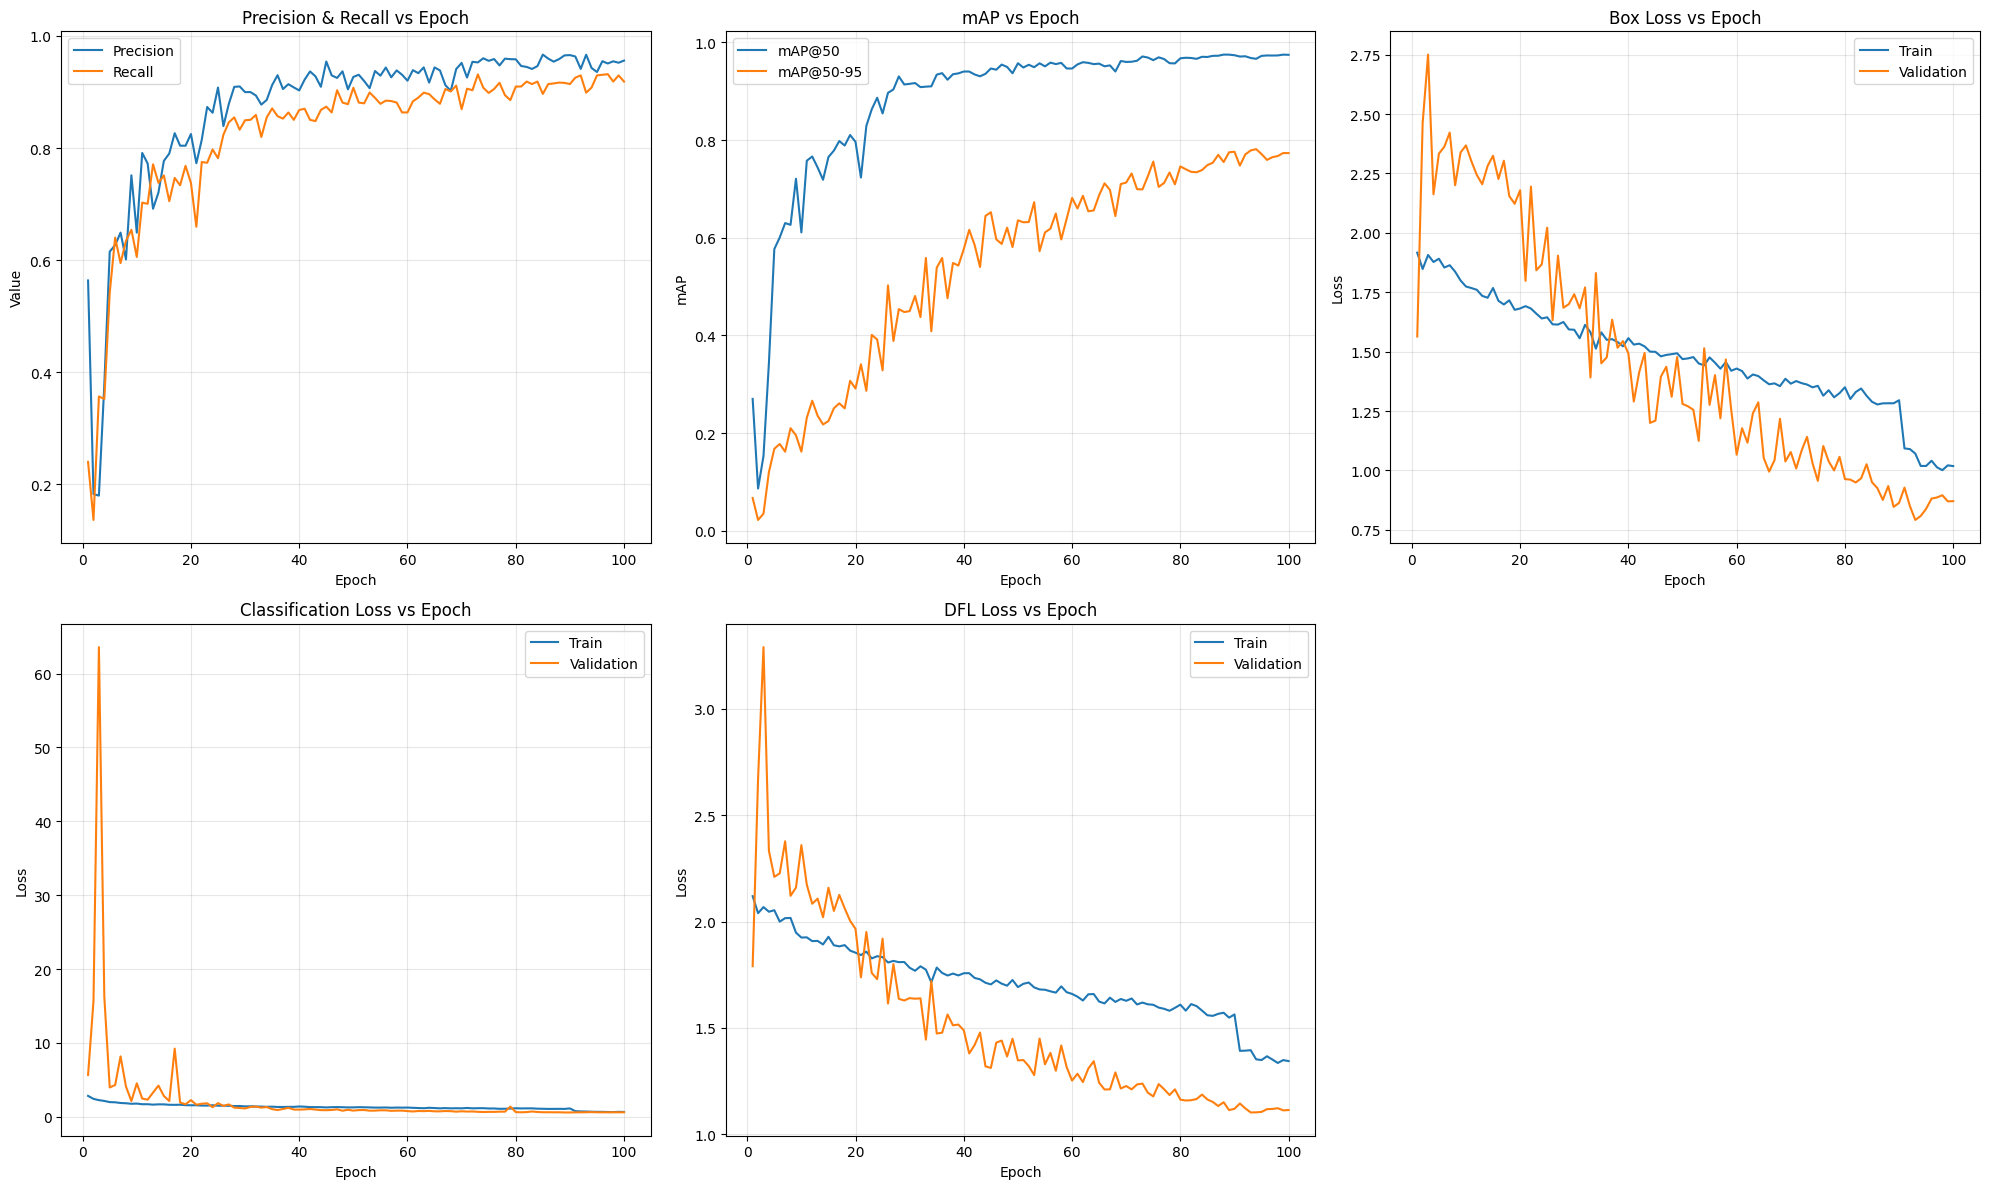


image 1/1 /content/triangle_dataset/images/1148.jpg: 640x640 1 triangle, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/triangle_dataset/images/539.jpg: 640x640 1 triangle, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/triangle_dataset/images/1110.jpg: 640x640 3 triangles, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/triangle_dataset/images/1499.jpg: 640x640 3 triangles, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/triangle_dataset/images/751.jpg: 640x640 4 triangles, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/triangle_dataset/images/122.jpg: 640x640 (no detections), 10.8ms
Speed: 2.3ms preprocess, 10.8ms in

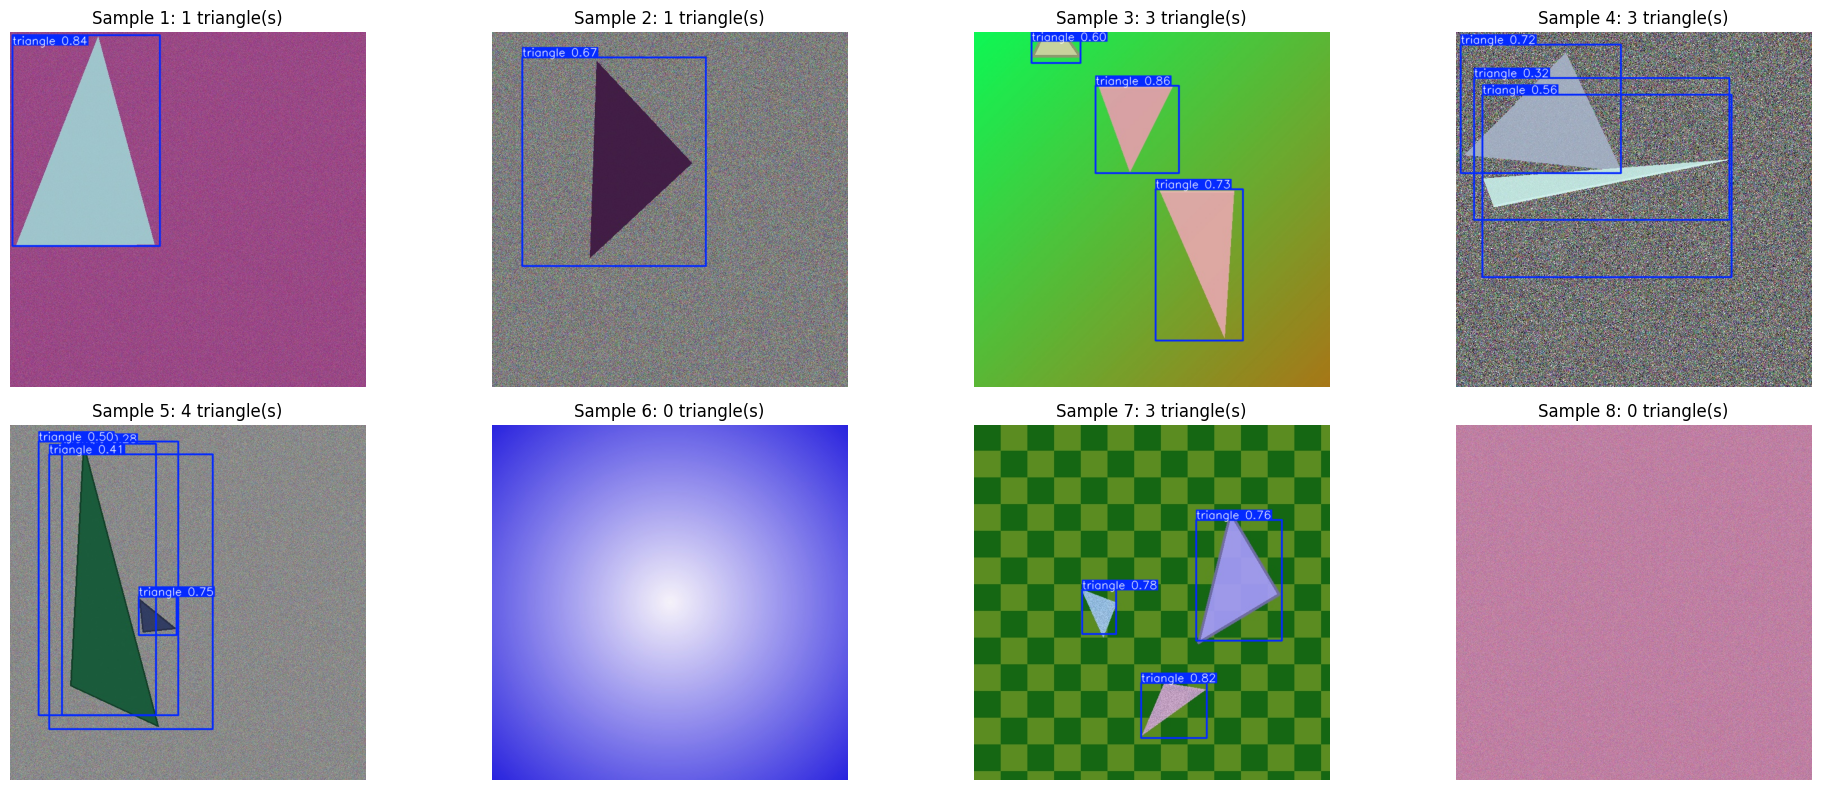

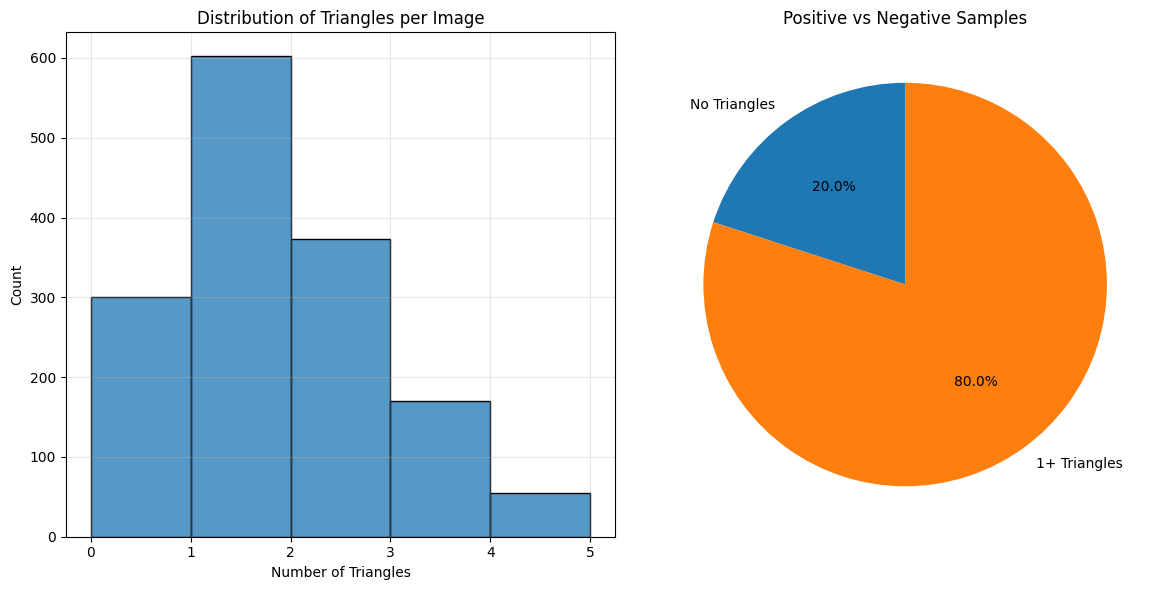

In [10]:
def visualize_results(model, metrics=None):
    """Create comprehensive visualizations of model performance"""
    if CFG.PLOT_METRICS:
        plt.figure(figsize=(20, 12))

        # Plot training curves
        try:
            results_file = f"{CFG.SAVE_DIR}/triangle_detection/results.csv"
            if os.path.exists(results_file):
                import pandas as pd
                results_df = pd.read_csv(results_file)

                plt.subplot(2, 3, 1)
                plt.plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision')
                plt.plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall')
                plt.title('Precision & Recall vs Epoch')
                plt.xlabel('Epoch')
                plt.ylabel('Value')
                plt.legend()
                plt.grid(True, alpha=0.3)

                plt.subplot(2, 3, 2)
                plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP@50')
                plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP@50-95')
                plt.title('mAP vs Epoch')
                plt.xlabel('Epoch')
                plt.ylabel('mAP')
                plt.legend()
                plt.grid(True, alpha=0.3)

                plt.subplot(2, 3, 3)
                plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train')
                plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Validation')
                plt.title('Box Loss vs Epoch')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True, alpha=0.3)

                plt.subplot(2, 3, 4)
                plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Train')
                plt.plot(results_df['epoch'], results_df['val/cls_loss'], label='Validation')
                plt.title('Classification Loss vs Epoch')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True, alpha=0.3)

                plt.subplot(2, 3, 5)
                plt.plot(results_df['epoch'], results_df['train/dfl_loss'], label='Train')
                plt.plot(results_df['epoch'], results_df['val/dfl_loss'], label='Validation')
                plt.title('DFL Loss vs Epoch')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True, alpha=0.3)

        except Exception as e:
            print(f"Warning: Could not plot training curves - {e}")

        plt.tight_layout()
        plt.savefig(f"{CFG.SAVE_DIR}/training_curves.png")
        plt.show()

    # Visualize predictions on test samples
    test_files = []
    with open(f"{CFG.BASE_DIR}/test.txt", 'r') as f:
        test_files = f.readlines()

    test_files = [line.strip() for line in test_files]

    if test_files:
        num_samples = min(CFG.TEST_SAMPLES, len(test_files))
        test_images = np.random.choice(test_files, num_samples, replace=False)

        fig, axes = plt.subplots(2, num_samples//2, figsize=(20, 8))
        axes = axes.flatten()

        for i, (ax, img_path) in enumerate(zip(axes, test_images)):
            results = model.predict(img_path, conf=0.25)

            plotted = results[0].plot(line_width=2, font_size=14)

            ax.imshow(cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB))

            num_detections = len(results[0].boxes)
            ax.set_title(f"Sample {i+1}: {num_detections} triangle(s)")
            ax.axis('off')

        plt.tight_layout()
        plt.savefig(f"{CFG.SAVE_DIR}/prediction_samples.png")
        plt.show()

    # Visualize triangle distribution
    triangle_counts = []
    for img_num in range(CFG.TOTAL_IMAGES):
        label_file = os.path.join(CFG.LABEL_DIR, f"{img_num}.txt")
        if os.path.exists(label_file):
            with open(label_file, 'r') as f:
                lines = f.readlines()
                triangle_counts.append(len(lines))

    if triangle_counts:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.histplot(triangle_counts, bins=range(max(triangle_counts)+2), kde=False)
        plt.title('Distribution of Triangles per Image')
        plt.xlabel('Number of Triangles')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        labels = ['No Triangles', '1+ Triangles']
        counts = [triangle_counts.count(0), sum(1 for x in triangle_counts if x > 0)]
        plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title('Positive vs Negative Samples')

        plt.tight_layout()
        plt.savefig(f"{CFG.SAVE_DIR}/dataset_distribution.png")
        plt.show()

metrics = evaluate_model(trained_model)
visualize_results(trained_model, metrics)

In [11]:
# %% Model Export and Deployment
def export_model():
    """Export the model to ONNX and TorchScript formats"""
    print("\nExporting model...")

    # Path to best model weights
    best_weights = f"{CFG.SAVE_DIR}/triangle_detection/weights/best.pt"

    if os.path.exists(best_weights):
        best_model = YOLO(best_weights)

        formats = ['onnx', 'torchscript']

        for format_type in formats:
            try:
                export_path = best_model.export(format=format_type)
                print(f"Exported model to {export_path}")
            except Exception as e:
                print(f"Failed to export to {format_type}: {e}")

        # Copy best model to Drive for safekeeping
        save_path = f"{CFG.SAVE_DIR}/best_triangle_detector.pt"
        shutil.copy(best_weights, save_path)
        print(f"Saved best model to {save_path}")
    else:
        print(f"Warning: Best model weights not found at {best_weights}")

In [12]:
# %% Inference Example
def inference_demo():
    """Demonstrate inference on a few test images"""
    print("\nRunning inference demo...")

    # Load best model
    best_model_path = f"{CFG.SAVE_DIR}/triangle_detection/weights/best.pt"
    if not os.path.exists(best_model_path):
        print(f"Model not found at {best_model_path}")
        return

    model = YOLO(best_model_path)

    with open(f"{CFG.BASE_DIR}/test.txt", 'r') as f:
        test_files = [line.strip() for line in f.readlines()]

    if not test_files:
        print("No test files found")
        return

    # Select a few random test images
    sample_size = min(5, len(test_files))
    samples = random.sample(test_files, sample_size)

    print("Running inference on sample images...")

    total_time = 0
    total_triangles = 0

    for img_path in samples:
        start_time = time.time()
        results = model.predict(img_path, conf=0.25, verbose=False)
        inference_time = time.time() - start_time

        total_time += inference_time
        num_triangles = len(results[0].boxes)
        total_triangles += num_triangles

        print(f"Image: {os.path.basename(img_path)} - Detected {num_triangles} triangles in {inference_time*1000:.1f}ms")

    # Calculate average inference time
    avg_time = total_time / sample_size * 1000

    print(f"\nAverage inference time: {avg_time:.2f}ms per image")
    print(f"Average triangles detected: {total_triangles/sample_size:.1f}")
    print(f"FPS: {1000/avg_time:.1f}")

export_model()

inference_demo()


Exporting model...
Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/triangle_detection_rerun/triangle_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.46', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 314.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 358.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 146.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 197.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 249.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 15.7s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim>=0.1.

In [13]:
# %% Keep Colab Session Alive
def keep_alive():
    """Colab session keep-alive function"""
    from IPython.display import Javascript
    display(Javascript('''
    function ClickConnect(){
        console.log("Keeping session alive");
        document.querySelector("colab-connect-button").click()
    }
    setInterval(ClickConnect, 60000)
    '''))

# Uncomment to keep session alive during long runs
# keep_alive()

In [14]:
# %% Summary and Conclusion
print(f"""
{'='*70}
Triangle Detection Model - Final Summary
{'='*70}

Dataset:
  - Total images: {CFG.TOTAL_IMAGES}
  - Positive/negative ratio: {1-CFG.NEGATIVE_RATIO:.1f}/{CFG.NEGATIVE_RATIO:.1f}
  - Image size: {CFG.IMG_SIZE}x{CFG.IMG_SIZE}
  - Background types: {', '.join(CFG.BG_TYPES)}
  - Triangle types: {', '.join(CFG.TRIANGLE_TYPES)}

Training:
  - Model: YOLOv8 Nano
  - Epochs: {CFG.EPOCHS} with patience {CFG.PATIENCE}
  - Batch size: {CFG.BATCH}
  - Augmentations: Rotation, scaling, flips, color jitter, etc.

Results:
  - Model saved to: {CFG.SAVE_DIR}/triangle_detection/weights/best.pt
  - Exported formats: ONNX, TorchScript

Next Steps:
  1. For deployment, use the exported models
  2. For further improvements:
     - Collect real-world triangle images
     - Fine-tune on domain-specific data
     - Try larger YOLOv8 models (s, m, l) for higher accuracy

Thank you for using the Triangle Detection System!
{'='*70}
""")


Triangle Detection Model - Final Summary

Dataset:
  - Total images: 1500
  - Positive/negative ratio: 0.8/0.2
  - Image size: 640x640
  - Background types: solid, gradient, noise, texture
  - Triangle types: regular, thin, obtuse, right

Training:
  - Model: YOLOv8 Nano
  - Epochs: 100 with patience 20
  - Batch size: 16
  - Augmentations: Rotation, scaling, flips, color jitter, etc.

Results:
  - Model saved to: /content/drive/MyDrive/triangle_detection_rerun/triangle_detection/weights/best.pt
  - Exported formats: ONNX, TorchScript

Next Steps:
  1. For deployment, use the exported models
  2. For further improvements:
     - Collect real-world triangle images
     - Fine-tune on domain-specific data
     - Try larger YOLOv8 models (s, m, l) for higher accuracy

Thank you for using the Triangle Detection System!

